**Hw3**

**Задание 1**

Написать логистическую регрессию.

log-los = $\frac{1}{n} \sum_{i=1}^n log(1 + e^{-y_i \cdot <x_i, \omega>}) .$

$L = log(1 + e^{-y_i \cdot <x_i, \omega>}).$

$L_{\omega_{j}}' = \frac{-y_i \cdot x_ij \cdot e^{-y_i \cdot <x_i, \omega>}}{1 + e^{-y_i \cdot <x_i, \omega>}}.$

Поэтому, $grad = X^T \cdot (- Y \cdot \frac{\cdot e^{-Y \cdot <X, \omega>}}{1 + e^{-Y \cdot <X, \omega>}})$

In [197]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Напишем и потестируем градиентный спуск.

In [1672]:
random_seed = 43
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 50
np.random.seed(random_seed)

# Генерим истинные веса
w_true = np.random.normal(size=(n_features, ))


# Под веса создаем признаки
X = np.random.uniform(-5, 5, (n_objects, n_features))

X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Создаем таргет
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)
for i in range(len(Y)):
    Y[i] = 1 if Y[i] > 0 else 0

In [1691]:
# Пишем градиентный спуск

w_0 = np.random.uniform(-2, 2, n_features)-0.5
w = w_0.copy()
w_list = [w.copy()]
learning_rate = 1e-5

for i in range(350):
    w -= learning_rate * (np.dot(X.T, -Y * (np.exp(np.dot(-Y, np.dot(X, w)))) \
                                 / (1 + np.exp(np.dot(-Y, np.dot(X, w))))))

    w_list.append(w.copy())
    
w_list = np.array(w_list)

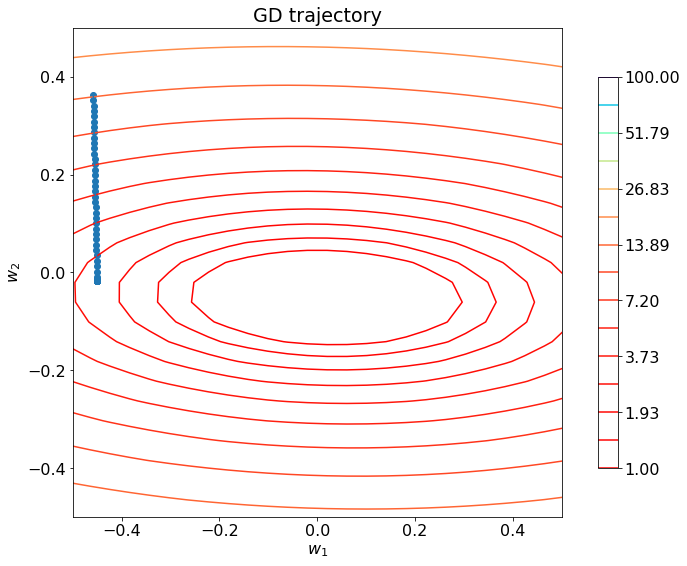

In [1693]:
matplotlib.rcParams.update({'font.size': 16})

# Визуализируем градиентный спуск
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.gca().set_aspect('equal')

CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=15), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()


Реализуем нашу собственную модель логистической регрессии:

In [1225]:
from sklearn.base import BaseEstimator, RegressorMixin

class LogReg(BaseEstimator, RegressorMixin):
    def __init__(self, num_steps=350, lr=1e-6):
        self.num_steps = num_steps
        self.lr = lr

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])

        for i in range(self.num_steps):
            w -= learning_rate * (np.dot(X.T, -Y * (np.exp(np.dot(-Y, np.dot(X, w)))) \
                                         / (1 + np.exp(np.dot(-Y, np.dot(X, w))))))
        self.w = w
        return self

    def predict(self, X):
        y = 1 / (1 + np.exp(-X @ self.w))
        for i in range(len(y)):
            y[i] = 1 if y[i] > 0.5 else 0
        return y

In [1226]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#Генерация данных для тестирования


from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
X, Y = load_breast_cancer(return_X_y=True)

In [1288]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [1289]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [1311]:
own_model = LogReg().fit(x_scaled, y_train)
y_pred = own_model.predict(x_test_scaled)
own_scope = accuracy_score(y_test, y_pred)

sklearn_model = LogisticRegression().fit(x_scaled, y_train)
y_pred = sklearn_model.predict(x_test_scaled)

sklearn_scope = accuracy_score(y_test, y_pred)

print('accuracy_score in own model:', own_scope)
print('accuracy_score in sklearn loss:', sklearn_scope)

accuracy_score in own model: 0.8601398601398601
accuracy_score in sklearn loss: 0.958041958041958


**Задание 2**

Реализовать свою модель линейной регрессии с регуляризацией и сравнить с моделью Ridge

Найдём оценку $\theta$ в модели ridge-регрессии.

$ F(\theta) = ||Y - X\cdot \theta||^2 + \lambda \cdot ||\theta||^2 = (Y - X \cdot \theta)^T \cdot (Y - X \cdot \theta) + \lambda \cdot \theta^T \cdot \theta = Y^T \cdot Y - 2 \cdot Y^T \cdot X \cdot \theta + \theta^T \cdot X^T \cdot X \cdot \theta + \lambda \cdot \theta^T \cdot \theta $

$ F'(\theta) = (Y^T \cdot Y)' - 2 \cdot (Y^T \cdot X \cdot \theta)' + (\theta^T \cdot X^T \cdot X \cdot \theta)' + (\lambda \cdot \theta^T \cdot \theta)' = 0 - 2 \cdot Y^T \cdot X + 2 \cdot \theta^T \cdot X^T \cdot X + 2 \cdot \lambda \cdot \theta^T = -2 \cdot Y^T \cdot X + \theta^T \cdot 2 \cdot (X^T \cdot X + \lambda \cdot E) = 0$

$\hat{\theta} = (X^T \cdot X + \lambda \cdot E)^{-1} \cdot X^T \cdot Y$


При  модели Ridge-регрессии даже если определитель матрицы $X^T \cdot X$ станет равен нулю, то $\lambda$ внесёт не нулевой вклад и обратная матрица $(X^T \cdot X + \lambda \cdot E)^{-1}$ будет существовать (если конечно $\lambda$ не будет являться собственным значением матрицы  $X^T \cdot X$, что возможно только в конечном количестве случаев).

Выпишим формулу поиска оценки коэффициентов методом градиентного спуска и стохастического градиентного спуска для модели ridge-регрессии.

$ \theta_{k+1} = \theta_k - \eta \cdot (\nabla F(\theta_k))$

$\nabla F(\theta_k) = 2(-Y^T \cdot X + \theta_k^T \cdot X^T \cdot X + \lambda \cdot \theta_k^T)^T$

Шаг GD: $\theta_{k+1} = \theta_k - \eta \cdot 2 \cdot (\theta_k^T \cdot X^T \cdot X - Y^T \cdot X + \lambda \cdot \theta_k^T)^T =
\theta_k - \eta \cdot 2\cdot (\cdot X^T \cdot (X \cdot \theta_k  - Y) + \lambda \cdot \theta_k^T))$

Шаг SGD: $\theta_{k+1} = \theta_k - \eta \cdot 2 \cdot (x_{i}^T \cdot (x_{i} \cdot \theta_k  - y_{i}) + \lambda \theta_k))$, где $i \sim U\{1,\ldots,n\}$ и $x_i$ - транспонированная $i$ строка матрицы $X$.


Шаг minbatch SGD: $\theta_{k+1} = \theta_k - \eta \cdot 2 \cdot \frac{n}{k} \cdot \sum_{j=1}^k (x_{i_j}\cdot (x_{i_j}^T \theta_k - y_{i_j}) + \frac{\lambda \theta_k}{n}), i \sim U\{1,\ldots,n\}$
Или в матричном виде: $\theta_{k+1} = \theta_k - \eta \cdot \frac{n}{k} \cdot X_{I}^T \cdot (X_{I} \theta_k - Y_{I}) + \lambda \theta_k, I = \{i_1 \cdots i_k\} \sim U\{1,\ldots,n\}$ с повторами, где матрица $X_i$ составлена из строк матрицы $X$ с номерами $I$, $Y_i$ -  аналогично.


**Реализуем** класс для работы с моделью ridge-регрессии. Интерфейс этого класса соответствует стандарту библиотеки sklearn

In [1700]:
class RidgeRegression:
    def __init__(self, lambd=0.1, fit_intercept=True):
        self.lambd = lambd
        self.fit_intercept = fit_intercept
         
    def fit(self, X, Y):
        if (self.fit_intercept):
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        else:
            X = np.hstack([X, np.ones((X.shape[0], 0))])
        self.theta = np.linalg.inv(X.T @ X + self.lambd * np.eye(X.shape[1])) @ X.T @ Y
        return self
    
    
    def predict(self, X):
        if (self.fit_intercept):
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        else:
            X = np.hstack([X, np.ones((X.shape[0], 0))])
        predictions = X @ self.theta
        return predictions

Сравним с моделью из коробки:

In [1701]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

#Генерация данных для тестирования
n_features = 700
n_objects = 100000

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [1702]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [1703]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [1704]:
own_model = RidgeRegression().fit(x_scaled, y_train)
y_pred = own_model.predict(x_test_scaled)
own_r2 = r2_score(y_test, y_pred)

sklearn_model = Ridge().fit(x_scaled, y_train)
y_pred = sklearn_model.predict(x_test_scaled)

sklearn_r2 = r2_score(y_test, y_pred)

print('R^2 in own model:', own_r2)
print('R^2 in sklearn loss:', sklearn_r2)

R^2 in own model: 0.9999999997963739
R^2 in sklearn loss: 0.9999999996219558


Хороший результат!